# Implementation of [Complex Networks Classification with Convolutional Neural Network](https://arxiv.org/pdf/1802.00539.pdf)

In [3]:
import networkx as nx
from karateclub import DeepWalk
import warnings
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA
import numpy as np
import io
import cv2
from tqdm import tqdm
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [4]:
rc('font', **{'family': 'sans-serif', 'sans-serif': ['DejaVu Sans'], 'size':13})
warnings.filterwarnings("ignore")

### Converting graph into image

1. Create graph embedding (using e.g. DeepWalk)
2. Use PCA to reduce the dimension of node representation into 2-d space
3. Rasterize the 2-d scatter plot into 48x48 grid. **In my implementation: convert matplotlib.plot into image and then create numpy array as input to the CNNs**
4. Count the number of nodes in each grid as the pixel grayscale
5. Input to CNN :)

![pipeline](pipeline.png)

In [5]:
def draw_network(g: nx.Graph, scale_size=True, node_size=40, edge_alpha=0.3):
    plt.figure(figsize=(8, 8))
    pos = nx.kamada_kawai_layout(g)
    if scale_size:
        d = [node_size * size for size in dict(g.degree).values()]
    else:
        d = [node_size] * len(g)
    nx.draw_networkx(g, pos=pos, with_labels=False, node_size=1, alpha=0)
    nx.draw_networkx_edges(g, pos=pos, alpha=edge_alpha)
    nx.draw_networkx_nodes(g, pos=pos, node_size=d, node_color='darkorange', edgecolors='black')
    plt.axis('off')

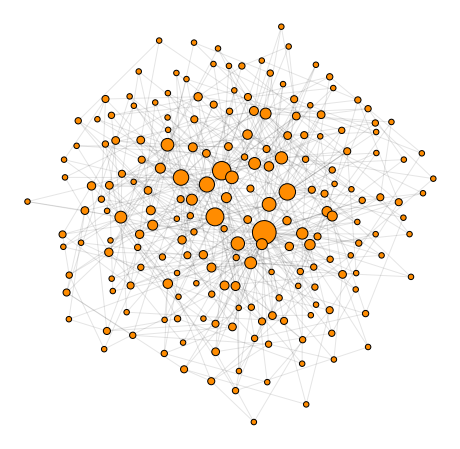

In [6]:
ba = nx.barabasi_albert_graph(200, m=3)
draw_network(ba, node_size=10, edge_alpha=0.1)
# plt.savefig('ba_network.png', dpi=300, bbox_layout=True)

In [7]:
def deep_walk(g, walk_number=10, walk_length=80, dimensions=128):
    model = DeepWalk(walk_number=walk_number, walk_length=walk_length, dimensions=dimensions)
    model.fit(g)
    return model.get_embedding()


def get_pca_components(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(embeddings)
    return pca.components_


def draw_embeddings(pca_components):
    plt.scatter(pca_components[0, :], pca_components[1, :])
    plt.title("2D embeddings of network")
    
    
def get_img_from_fig(fig, dpi=200, new_size=(64, 64)):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, new_size)
    return img


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def get_image_from_embeddings(pca_components, input_size=(64, 64)):
    """
    Based on: https://stackoverflow.com/a/58641662/9511702
    """
    fig = plt.figure(figsize=(6, 6))
    fig.tight_layout(pad=0)
    plt.scatter(pca_components[0, :], pca_components[1, :], alpha=0.3)
    plt.axis('off')
    plt.xticks([], [])
    image = get_img_from_fig(fig, new_size=input_size)
    image_greyscale = rgb2gray(image)
    image_greyscale = np.reshape(image_greyscale, newshape=(image_greyscale.shape[0], image_greyscale.shape[1], 1))
    plt.close()
    return image_greyscale


def plot_network_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image[:, :, 0], cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [8]:
a = get_pca_components(deep_walk(ba).T)

In [9]:
a.shape

(2, 200)

In [10]:
res = get_image_from_embeddings(a)

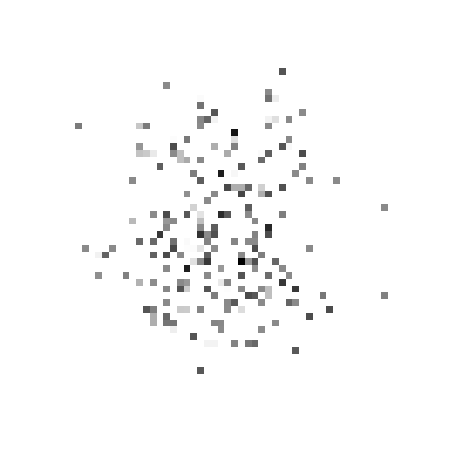

In [11]:
plot_network_image(res)
# plt.savefig('ba_network_after.png', dpi=300, bbox_layout=True)

|   **Intput BA network** | **After pipeline** |
|:-:	|:-:	|
| ![](ba_network.png)| ![](ba_network_after.png) |

In [12]:
def create_synthetic_input(size, k, network_type='BA', input_size=(100, 100)):
    if network_type == 'BA':
        network = nx.barabasi_albert_graph(size, m=(int)(k / 2))
    elif network_type == 'WS':
        network = nx.watts_strogatz_graph(size, k, p=0.1)
    else:
        print('Wrong network type. Available `BA`, `WS`.')
    
    embedding = get_pca_components(deep_walk(network).T)
    return network_type, get_image_from_embeddings(embedding, input_size)


def save_networks(file, networks):
    with open('data/' + file + '.pickle', 'wb') as f:
        pickle.dump(networks, f)

        
def load_networks(file):
    with open('data/' + file + '.pickle', 'rb') as f:
        return pickle.load(f)

In [11]:
N = 100
k = 4
LENGTH = 2000

ba_networks = []
ws_networks = []


for n in tqdm(range(LENGTH)):
    ba = create_synthetic_input(N, k) 
    ws = create_synthetic_input(N, k, network_type='WS')
    
    ba_networks.append(ba)
    ws_networks.append(ws)
    
save_networks(f'ba_networks_N={N}_k={k}_length={LENGTH}', ba_networks)
save_networks(f'ws_networks_N={N}_k={k}_length={LENGTH}', ba_networks)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [37:41<00:00,  1.15s/it]


### Split train/test data

In [22]:
import glob


def load_network_in_parts(path):
    network = []
    for net in glob.glob(path):
        network += load_networks(net.split('\\')[-1].split('.')[0])
    return network
    

ba_networks = load_network_in_parts('data/ba*')
ws_networks = load_network_in_parts('data/ws*')

In [23]:
ba_label, ba_data = zip(*ba_networks)
ws_label, ws_data = zip(*ws_networks)

In [24]:
label = np.array(list(ba_label + ws_label))
network_data = np.array(list(ba_data + ws_data))

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(network_data, label, test_size=0.1, random_state=32)

In [26]:
len(X_train), len(X_test), X_train.shape

(3600, 400, (3600, 100, 100, 1))

### Create CNN

In [27]:
IMG_HEIGHT = 100
IMG_WIDTH = 100

In [34]:
model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 64)      640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)       

In [ ]:
EPOCHS = 10
BATCH_SIZE = 128

history = model.fit(X_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE)

Train on 3600 samples
Epoch 1/10


In [ ]:
# TODO -- rewrite to Pytorch, here I cannot start training...